In [1]:
import pandas as pd
import pickle
import numpy as np
from scipy import stats
from collections import defaultdict
from ast import literal_eval
import matplotlib.pyplot as plt

In [2]:
# read in the data
with open("../../data/qualitative_data/individual_model_all_scores.p", "rb") as fp:
    all_model_scores = pickle.load(fp)

with open("../../data/qualitative_data/all_individual_exogenous_variables.p", "rb") as fp:
    all_model_exo = pickle.load(fp)
    
with open("../../data/qualitative_data/all_lqr_scores.p", "rb") as fp:
    lqr_scores = pickle.load(fp)

with open("../../data/qualitative_data/all_lqr_exo.p", "rb") as fp:
    lqr_exo = pickle.load(fp)
    
results_folder = "../../figures/"
all_model_scores['lqr'] = lqr_scores
all_model_exo['lqr'] = lqr_exo

In [4]:
len(all_model_scores["sparse_max_continuous"]) / 12

300.0

In [7]:
# print all the median model scores
for model in all_model_scores:
    med = np.median(all_model_scores[model])
    iqr = stats.iqr(all_model_scores[model])
    print(f"{model}: {np.round(med,1)}, iqr={np.round(iqr,1)} [{med - iqr/2}, {med + iqr/2}]")

null_model_2: 500.9, iqr=528.0 [236.91684727777596, 764.9040272111379]
sparse_max_discrete: 123.9, iqr=126.0 [60.86222567251533, 186.87946027883544]
sparse_lqr: 74.7, iqr=116.1 [16.645291054887075, 132.6990156448083]
hill_climbing: 128.7, iqr=109.5 [73.97151079613955, 183.4952325439644]
null_model_1: 426.1, iqr=485.5 [183.3399902305513, 668.8194545512766]
sparse_max_continuous: 308.8, iqr=365.9 [125.83876113971226, 491.70191536924426]
lqr: 4.7, iqr=4.0 [2.6952587366104126, 6.70369279384613]


In [8]:
# compile the norm standard deviation and number of variables into a dictionary for each model
all_model_n_var = defaultdict(list)
all_model_norm_std = defaultdict(list)
for model in all_model_exo:
    for action in all_model_exo[model]:
        all_model_n_var[model].append(len([x for x in action if x != 0]))
    
    for i in range(0,len(all_model_exo[model]),10):
        run = all_model_exo[model][i:i+10]
        all_model_norm_std[model].append(np.std([np.linalg.norm(x) for x in run]))

In [9]:
# print the medians and interquartile ranges for number of variables manipulated
for model in all_model_n_var:
    med = np.median(all_model_n_var[model])
    iqr = stats.iqr(all_model_n_var[model])
    print(f"{model}: {med}, iqr={iqr} [{med - iqr/2}, {med + iqr/2}]")

null_model_2: 0.0, iqr=0.0 [0.0, 0.0]
sparse_max_discrete: 1.0, iqr=1.0 [0.5, 1.5]
sparse_lqr: 1.0, iqr=2.0 [0.0, 2.0]
hill_climbing: 4.0, iqr=0.0 [4.0, 4.0]
null_model_1: 1.0, iqr=1.0 [0.5, 1.5]
sparse_max_continuous: 1.0, iqr=2.0 [0.0, 2.0]
lqr: 4.0, iqr=0.0 [4.0, 4.0]


In [11]:
# print the medians and interquartile ranges for the standard deviation of input norms
for model in all_model_norm_std:
    med = np.median(all_model_norm_std[model])
    iqr = stats.iqr(all_model_norm_std[model])
    print(f"{model}: {np.round(med,2)}, iqr={np.round(iqr,2)} [{med - iqr/2}, {med + iqr/2}]")

null_model_2: 0.0, iqr=0.0 [0.0, 0.0]
sparse_max_discrete: 12.87, iqr=13.83 [5.960026166219294, 19.787442724262192]
sparse_lqr: 12.42, iqr=37.76 [-6.461994932120582, 31.29920101061814]
hill_climbing: 2.51, iqr=3.14 [0.9378281029753368, 4.077573281444254]
null_model_1: 0.62, iqr=0.31 [0.46379272533603055, 0.7738539513091824]
sparse_max_continuous: 6.34, iqr=27.92 [-7.622142991195899, 20.299455184565964]
lqr: 1.1, iqr=0.89 [0.6592507796143575, 1.5443659473382652]


In [8]:
pp_data_file = '../../data/experimental_data/experiment_actions.csv'
n_pps = 111

In [9]:
df_data = pd.read_csv(pp_data_file)
df_pps = df_data.loc[df_data.groupby('pp_id')['id'].idxmax()]
df_pps['root_cost'] = df_pps['total_cost'].apply(np.sqrt)

In [10]:
n_var = df_data['exogenous_input'].apply(lambda x: len([y for y in literal_eval(x) if y != 0]))

In [11]:
stats.iqr(list(n_var))

2.0

In [12]:
stats.kruskal(all_model_scores['lqr'], df_pps['root_cost'])

KruskalResult(statistic=180.58857243767764, pvalue=3.6050576193048015e-41)

Plot histograms of model performances and qualitative measures

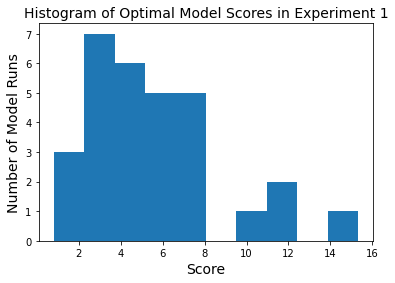

In [13]:
# Plot the LQR scores with a scale appropriate for the scores it achieves
plt.hist(all_model_scores['lqr'][:30])
plt.title("Histogram of Optimal Model Scores in Experiment 1", fontsize=14)
plt.ylabel("Number of Model Runs", fontsize=14)
plt.xlabel("Score", fontsize=14)
plt.savefig("../../figures/lqr_scores_newscale.pdf")

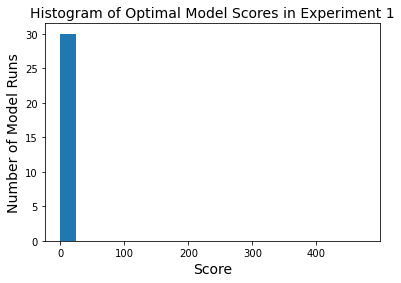

In [14]:
# Plot the LQR scores with the same scale as the human performance plot
plt.hist(all_model_scores['lqr'][:30], bins=np.arange(0,500,25))
plt.title("Histogram of Optimal Model Scores in Experiment 1", fontsize=14)
plt.ylabel("Number of Model Runs", fontsize=14)
plt.xlabel("Score", fontsize=14)
plt.savefig("../../figures/lqr_scores_samescale.pdf")

Plot the standard deviation of input norms for each model type

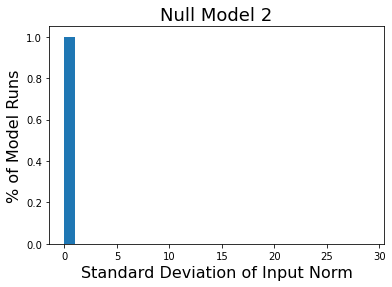

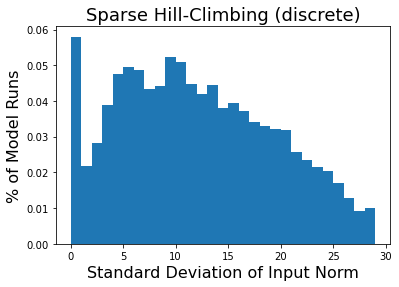

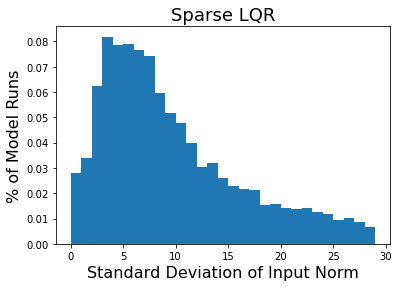

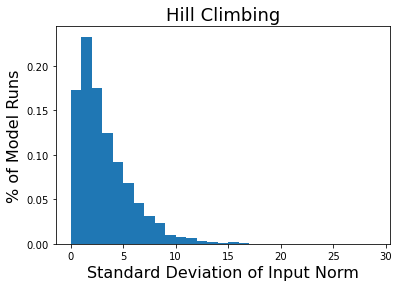

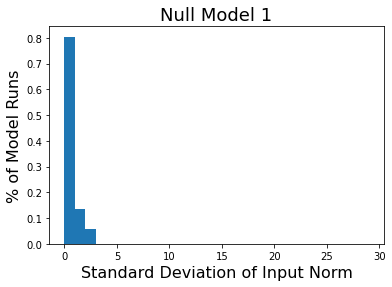

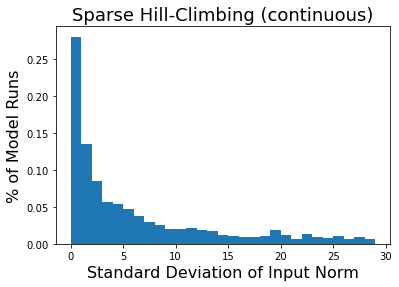

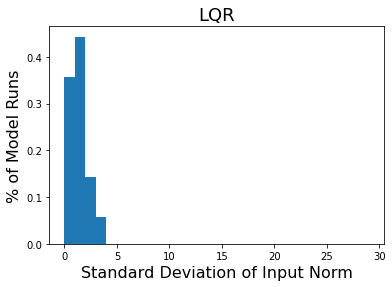

In [15]:
model_names = {"null_model_2": "Null Model 2", "null_model_1": "Null Model 1", "sparse_lqr": "Sparse LQR", "sparse_max_discrete": "Sparse Hill-Climbing (discrete)", "sparse_max_continuous": "Sparse Hill-Climbing (continuous)", "hill_climbing": "Hill Climbing", "lqr": "LQR"}
all_model_input_norm_stds = {}
for model_type in all_model_exo.keys():
    input_norm_stds = []
    
    for i in range(0,len(all_model_exo[model_type]),10):
        run = all_model_exo[model_type][i:i+10]
        input_norm_stds.append(np.std([np.linalg.norm(x) for x in run]))
        all_model_input_norm_stds[model_type] = input_norm_stds
        
    bins = np.arange(0,30,1)
    plt.hist(input_norm_stds, bins, density=True)
    plt.title(f"{model_names[model_type]}", fontsize=18)
    plt.xlabel("Standard Deviation of Input Norm", fontsize=16)
    plt.ylabel("% of Model Runs", fontsize=16)
    plt.savefig(results_folder + f"input_norms_{model_type}.pdf")
    plt.show()

Plot the number of variables manipulated for each model type

null_model_2


<ipython-input-25-e62f52b38831>:16: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


sparse_max_discrete


<ipython-input-25-e62f52b38831>:16: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


sparse_lqr


<ipython-input-25-e62f52b38831>:16: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


hill_climbing


<ipython-input-25-e62f52b38831>:16: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


null_model_1


<ipython-input-25-e62f52b38831>:16: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


sparse_max_continuous


<ipython-input-25-e62f52b38831>:16: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
<ipython-input-25-e62f52b38831>:16: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


lqr


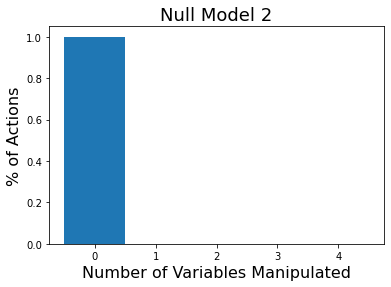

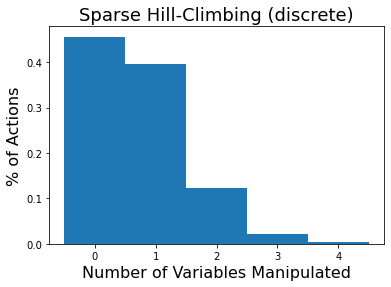

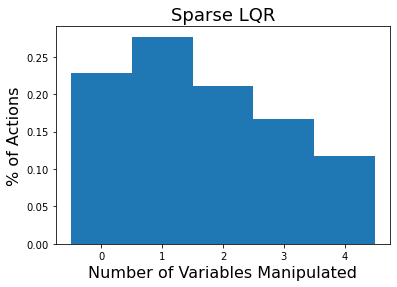

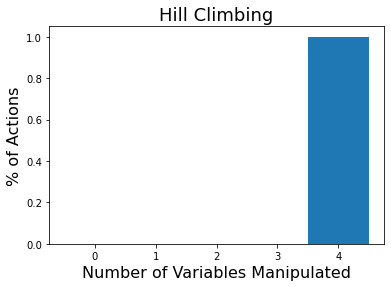

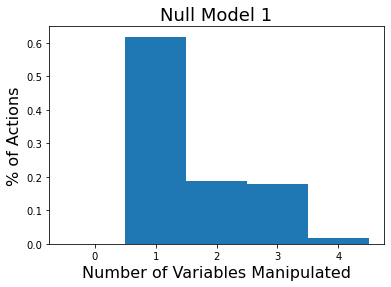

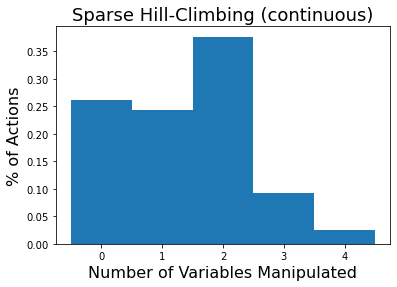

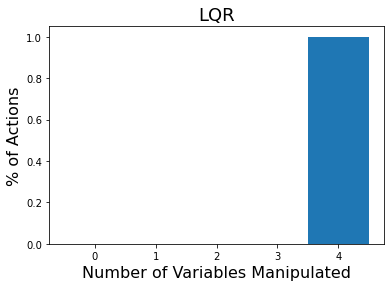

In [25]:
for model_type in all_model_exo.keys():
    print(model_type)
    all_n_var = []
    for exo in all_model_exo[model_type]:
        all_n_var.append(len([x for x in exo if x != 0]))
    
    bins = np.arange(0,6,1)
    fig, ax = plt.subplots()
    ax.hist(all_n_var, bins, density=True)
    ax.set_title(f"{model_names[model_type]}", fontsize=18)
    ax.set_xlabel("Number of Variables Manipulated", fontsize=16)
    ax.set_ylabel("% of Actions", fontsize=16)
    ax.set_xticks(np.arange(0.5, 5.5, 1))
    ax.set_xticklabels(range(5))
    fig.savefig(results_folder + f"n_vars_{model_type}.pdf")
    fig.show()

In [17]:
df_human = pd.read_csv('../../data/experimental_data/experiment_actions.csv')

In [18]:
all_human_exo = [literal_eval(x) for x in df_human['exogenous_input']]

In [19]:
all_human_norms = [np.linalg.norm(exo) for exo in all_human_exo]
all_human_n_var = [len([x for x in exo if x == 0]) for exo in all_human_exo]

In [20]:
df_human

,Unnamed: 0,closeness,condition,endogenous,exogenous_input,final_goal_distance,final_reached,id,input_cost,pp_id,seconds,total_cost
0,0,333.983173,51,"[206.0, -151.0, 29.0, -117.4, -178.0]","[0.0, 0.0, -10.0, 0.0]",333.983173,0.0,0.0,1.00,5f35d6ae93a88f0023c8d644,14.449,111545.76
1,1,302.287016,51,"[206.0, -62.0, 118.0, -78.8, -158.0]","[0.0, 2.0, 0.0, 0.0]",302.287016,0.0,1.0,0.04,5f35d6ae93a88f0023c8d644,9.787,91378.48
2,2,315.490158,51,"[206.0, 17.0, 197.0, -40.199999999999996, -128.0]","[0.0, 3.0, 0.0, 0.0]",315.490158,0.0,2.0,0.09,5f35d6ae93a88f0023c8d644,13.052,99535.17
3,3,358.865657,51,"[206.0, 81.0, 261.0, -1.5999999999999943, -108.0]","[0.0, 2.0, 0.0, 0.0]",358.865657,0.0,3.0,0.04,5f35d6ae93a88f0023c8d644,19.883,128785.73
4,4,424.755518,51,"[208.0, 140.0, 323.0, 39.500000000000014, -108.0]","[1.0, 0.0, 1.0, 1.0]",424.755518,0.0,4.0,0.03,5f35d6ae93a88f0023c8d644,11.088,180418.45
...,...,...,...,...,...,...,...,...,...,...,...,...
1104,1104,177.365752,25,"[168.0, 16.0, -41.0, 11.900000000000006, -34.0]","[-2.0, -4.0, 4.0, -4.0]",177.365752,0.0,1104.0,0.52,5f362dee93a88f0023c91131,47.006,31466.26
1105,1105,172.331802,25,"[154.0, 23.0, -65.0, 8.500000000000007, -34.0]","[-2.0, 0.0, -7.0, -5.0]",172.331802,0.0,1105.0,0.78,5f362dee93a88f0023c91131,46.090,29706.68
1106,1106,170.364345,25,"[166.0, 25.0, -27.0, 9.90000000000001, -4.0]","[-3.0, 3.0, 6.0, -5.0]",170.364345,0.0,1106.0,0.79,5f362dee93a88f0023c91131,26.665,29033.23
1107,1107,177.409583,25,"[176.0, 12.0, -9.0, 15.400000000000013, 6.0]","[-3.0, 1.0, 5.0, -5.0]",177.409583,0.0,1107.0,0.60,5f362dee93a88f0023c91131,27.963,31483.98


Plot the standard deviation of input norm and number of variables manipulated for humans

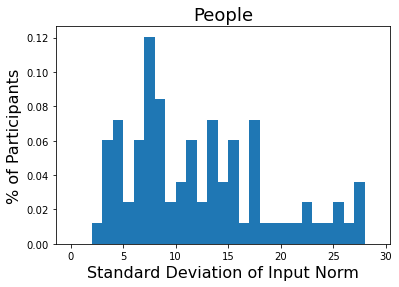

In [21]:
bins = np.arange(0,30,1)
human_input_norm_stds = []

for pp in df_human['pp_id'].drop_duplicates():
    df_pp = df_human[df_human['pp_id'] == pp]
    run = df_pp['exogenous_input']
    human_input_norm_stds.append(np.std([np.linalg.norm(literal_eval(x)) for x in run]))

plt.hist(human_input_norm_stds, bins, density=True)
plt.title(f"People", fontsize=18)
plt.xlabel("Standard Deviation of Input Norm", fontsize=16)
plt.ylabel("% of Participants", fontsize=16)
plt.savefig(results_folder + f"input_norms_human.pdf")

plt.show()

<ipython-input-22-01e06de7d01d>:10: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


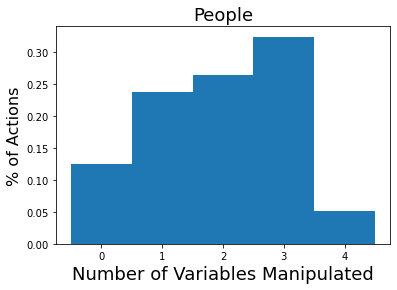

In [22]:
bins = np.arange(0,6,1)
fig, ax = plt.subplots()
ax.hist(all_human_n_var, bins, density=True)
ax.set_title(f"People", fontsize=18)
ax.set_xlabel("Number of Variables Manipulated", fontsize=18)
ax.set_ylabel("% of Actions", fontsize=16)
ax.set_xticks(np.arange(0.5, 5.5, 1))
ax.set_xticklabels(range(5))
fig.savefig(results_folder + f"n_vars_human.pdf")
fig.show()

Run the statistical tests

In [23]:
for model in all_model_n_var:
    print(f"humans vs {model}: {np.median(all_human_n_var)} vs. {np.median(all_model_n_var[model])} {stats.kruskal(all_human_n_var, all_model_n_var[model])}")

humans vs null_model_2: 2.0 vs. 0.0 KruskalResult(statistic=11313.673691530128, pvalue=0.0)
humans vs sparse_max_discrete: 2.0 vs. 1.0 KruskalResult(statistic=1345.2811994141482, pvalue=1.6334676498510287e-294)
humans vs sparse_lqr: 2.0 vs. 1.0 KruskalResult(statistic=64.16890632090248, pvalue=1.141968646286156e-15)
humans vs hill_climbing: 2.0 vs. 4.0 KruskalResult(statistic=77904.03156278853, pvalue=0.0)
humans vs null_model_1: 2.0 vs. 1.0 KruskalResult(statistic=159.8489090954246, pvalue=1.2208434393276059e-36)
humans vs sparse_max_continuous: 2.0 vs. 1.0 KruskalResult(statistic=276.44818834200163, pvalue=4.462875821048062e-62)
humans vs lqr: 2.0 vs. 4.0 KruskalResult(statistic=2094.5546995027803, pvalue=0.0)


In [24]:
for model in all_model_input_norm_stds:
    print(f"humans vs {model}: {np.median(human_input_norm_stds)} vs. {np.median(all_model_input_norm_stds[model])} {stats.kruskal(human_input_norm_stds, all_model_input_norm_stds[model])}")

humans vs null_model_2: 14.681139904908841 vs. 0.0 KruskalResult(statistic=1306.5892914504045, pvalue=4.180989381202438e-286)
humans vs sparse_max_discrete: 14.681139904908841 vs. 12.873734445240743 KruskalResult(statistic=7.106537224161534, pvalue=0.007680333133881478)
humans vs sparse_lqr: 14.681139904908841 vs. 12.41860303924878 KruskalResult(statistic=0.26247956207682666, pvalue=0.6084217572207118)
humans vs hill_climbing: 14.681139904908841 vs. 2.507700692209795 KruskalResult(statistic=262.7434922891698, pvalue=4.330241988858764e-59)
humans vs null_model_1: 14.681139904908841 vs. 0.6188233383226065 KruskalResult(statistic=309.8188601703432, pvalue=2.3915794933832224e-69)
humans vs sparse_max_continuous: 14.681139904908841 vs. 6.338656096685032 KruskalResult(statistic=25.496342727784803, pvalue=4.43222291336601e-07)
humans vs lqr: 14.681139904908841 vs. 1.1018083634763114 KruskalResult(statistic=183.802333756147, pvalue=7.165778314407158e-42)
